In [1]:
pip install --upgrade wandb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install transformers

In [4]:
 !pip install colorama

In [5]:
import os
import gc
import copy
import time
import random
import string

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AdamW

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [6]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
    anony = None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. 
Get your W&B access token from here: https://wandb.ai/authorize


In [7]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))

HASH_NAME = id_generator(size=12)
print(HASH_NAME)

4yyqdj6zppxy


In [8]:
CONFIG = {"seed": 2022, #2021->42
          "epochs": 20, #3->5->10->7->3
          "model_name": "roberta-base",
          "train_batch_size": 32,
          "valid_batch_size": 32,
          "max_length": 128,
          "learning_rate": 0.5e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-8,
          "T_max": 500,
          "weight_decay": 1e-8,
          "n_fold": 5, #5->10->5->10
          "n_accumulate": 1,
          "num_classes": 1,
          "margin": 0.5,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'

In [9]:
def set_seed(seed=2022):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [10]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Jigsaw/csvまとめ/validation_data_from_ruddit200000.csv")

In [11]:
df

,Unnamed: 0,less_toxic,more_toxic
0,0,Not really. California came at a point when it...,Note to self: Avoid Westminster if visiting L...
1,1,And then declining to spend money at the NFL. ...,This lady is stupid as fuck if you research ha...
2,2,"Wait, so how did you get here then?",America is the land of the free sandwiched bet...
3,3,None of my friends throw a New Year's eve part...,Dragonflies do not often live indoors and prot...
4,4,My best ks 6:39\n..gonna go in and start at 9 ...,"Not me, but my best friend. She got pregnant l..."
...,...,...,...
197550,197550,"Shh not yet, poppa Soros hasn't given us the w...","In Latin America I took a cab, those drivers d..."
197551,197551,The specificity of your view and motivation ar...,Walmart? You'll need to hit up target to get t...
197552,197552,Different sparks for different ranks. Admiral ...,Looks like his name is Yevgeny Prigozhin. The ...
197553,197553,As far as I can tell he just fell asleep in ph...,Are you saying people who pay more and buy tic...


In [12]:
num_bins = int(np.floor(1+np.log2(len(df))))

In [13]:
df['bins'] = pd.cut(df['Unnamed: 0'], bins=num_bins, labels=False)

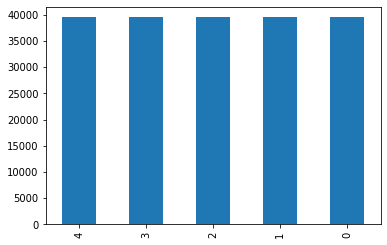

In [14]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
seed=2022

df['kfold'] = -1

#層化抽出法を用いることでランダムにfoldしている
N_FOLDS = 5
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(df.index, df['bins'])):
    df.iloc[train_index, -1] = i
    
df['kfold'] = df['kfold'].astype('int')

df.kfold.value_counts().plot.bar()

In [15]:
df.drop('bins', axis=1, inplace=True)

In [16]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [17]:
df

,less_toxic,more_toxic,kfold
0,Not really. California came at a point when it...,Note to self: Avoid Westminster if visiting L...,1
1,And then declining to spend money at the NFL. ...,This lady is stupid as fuck if you research ha...,4
2,"Wait, so how did you get here then?",America is the land of the free sandwiched bet...,0
3,None of my friends throw a New Year's eve part...,Dragonflies do not often live indoors and prot...,2
4,My best ks 6:39\n..gonna go in and start at 9 ...,"Not me, but my best friend. She got pregnant l...",2
...,...,...,...
197550,"Shh not yet, poppa Soros hasn't given us the w...","In Latin America I took a cab, those drivers d...",2
197551,The specificity of your view and motivation ar...,Walmart? You'll need to hit up target to get t...,3
197552,Different sparks for different ranks. Admiral ...,Looks like his name is Yevgeny Prigozhin. The ...,4
197553,As far as I can tell he just fell asleep in ph...,Are you saying people who pay more and buy tic...,0


In [18]:
class JigsawDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.more_toxic = df['more_toxic'].values
        self.less_toxic = df['less_toxic'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        more_toxic = self.more_toxic[index]
        less_toxic = self.less_toxic[index]
        inputs_more_toxic = self.tokenizer.encode_plus(
                                more_toxic,
                                truncation=True,
                                add_special_tokens=True,
                                max_length=self.max_len,
                                padding='max_length'
                            )
        inputs_less_toxic = self.tokenizer.encode_plus(
                                less_toxic,
                                truncation=True,
                                add_special_tokens=True,
                                max_length=self.max_len,
                                padding='max_length'
                            )
        target = 1
        
        more_toxic_ids = inputs_more_toxic['input_ids']
        more_toxic_mask = inputs_more_toxic['attention_mask']
        
        less_toxic_ids = inputs_less_toxic['input_ids']
        less_toxic_mask = inputs_less_toxic['attention_mask']
        
        
        return {
            'more_toxic_ids': torch.tensor(more_toxic_ids, dtype=torch.long),
            'more_toxic_mask': torch.tensor(more_toxic_mask, dtype=torch.long),
            'less_toxic_ids': torch.tensor(less_toxic_ids, dtype=torch.long),
            'less_toxic_mask': torch.tensor(less_toxic_mask, dtype=torch.long),
            'target': torch.tensor(target, dtype=torch.long)
        }

In [19]:
class JigsawModel(nn.Module):
    def __init__(self, model_name):
        super(JigsawModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.drop(out[1])
        outputs = self.fc(out)
        return outputs

In [20]:
def criterion(outputs1, outputs2, targets):
    return nn.MarginRankingLoss(margin=CONFIG['margin'])(outputs1, outputs2, targets)

In [21]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        more_toxic_ids = data['more_toxic_ids'].to(device, dtype = torch.long)
        more_toxic_mask = data['more_toxic_mask'].to(device, dtype = torch.long)
        less_toxic_ids = data['less_toxic_ids'].to(device, dtype = torch.long)
        less_toxic_mask = data['less_toxic_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = more_toxic_ids.size(0)

        more_toxic_outputs = model(more_toxic_ids, more_toxic_mask)
        less_toxic_outputs = model(less_toxic_ids, less_toxic_mask)
        
        loss = criterion(more_toxic_outputs, less_toxic_outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [22]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        more_toxic_ids = data['more_toxic_ids'].to(device, dtype = torch.long)
        more_toxic_mask = data['more_toxic_mask'].to(device, dtype = torch.long)
        less_toxic_ids = data['less_toxic_ids'].to(device, dtype = torch.long)
        less_toxic_mask = data['less_toxic_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = more_toxic_ids.size(0)

        more_toxic_outputs = model(more_toxic_ids, more_toxic_mask)
        less_toxic_outputs = model(less_toxic_ids, less_toxic_mask)
        
        loss = criterion(more_toxic_outputs, less_toxic_outputs, targets)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    gc.collect()
    
    return epoch_loss

In [23]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [24]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = JigsawDataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = JigsawDataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [25]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [26]:
cd /content/drive/MyDrive/Colab Notebooks/Jigsaw

/content/drive/MyDrive/Colab Notebooks/Jigsaw


In [ ]:
fold=0
print(f"{y_}====== Fold: {fold} ======{sr_}")
run = wandb.init(project='Jigsaw', 
                 config=CONFIG,
                 job_type='Train',
                 group=CONFIG['group'],
                 tags=['roberta-base', f'{HASH_NAME}', 'margin-loss'],
                 name=f'{HASH_NAME}-fold-{fold}',
                 anonymous='must')
    
# Create Dataloaders
train_loader, valid_loader = prepare_loaders(fold=fold)
    
model = JigsawModel(CONFIG['model_name'])
model.to(CONFIG['device'])
model.load_state_dict(torch.load(f'/content/drive/MyDrive/Colab Notebooks/Jigsaw/bert models for ruddit/Loss-Fold-0_epoch7.bin'))
  
# Define Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)
    
model, history = run_training(model, optimizer, scheduler,
                              device=CONFIG['device'],
                              num_epochs=CONFIG['epochs'],
                              fold=fold)
                         
run.finish()
    
del model, history, train_loader, valid_loader
_ = gc.collect()
print()

====== Fold: 0 ======


wandb: Currently logged in as: anony-moose-194716 (use `wandb login --relogin` to force relogin)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[INFO] Using GPU: Tesla T4



100%|██████████| 1235/1235 [09:37<00:00,  2.14it/s, Epoch=1, LR=4.81e-6, Valid_Loss=0.0514]


Validation Loss Improved (inf ---> 0.05135384742095616)
Model Saved



100%|██████████| 1235/1235 [09:36<00:00,  2.14it/s, Epoch=2, LR=4.28e-6, Valid_Loss=0.0438]


Validation Loss Improved (0.05135384742095616 ---> 0.04384944018344988)
Model Saved



100%|██████████| 1235/1235 [09:36<00:00,  2.14it/s, Epoch=3, LR=3.48e-6, Valid_Loss=0.042]


Validation Loss Improved (0.04384944018344988 ---> 0.04197527915263377)
Model Saved



100%|██████████| 1235/1235 [09:36<00:00,  2.14it/s, Epoch=4, LR=2.54e-6, Valid_Loss=0.0402]


Validation Loss Improved (0.04197527915263377 ---> 0.04021096054107899)
Model Saved



 39%|███▉      | 1929/4938 [42:53<1:06:56,  1.33s/it, Epoch=5, LR=1.46e-6, Train_Loss=0.032]